In [2]:
import numpy as np, cv2, glob, os, re, matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from pathlib import Path

## parte 1

### model

In [3]:
# usando todo en cm
res = 1025
l = 5
x = 10
a = 2.5e-3 # e-2 for 0.25mm
I0 = 1         # fuente: de los deseos
lmd = 5.32e-5

vec = np.linspace(-l/2, l/2, res)
Z, Y = np.meshgrid(vec, vec)

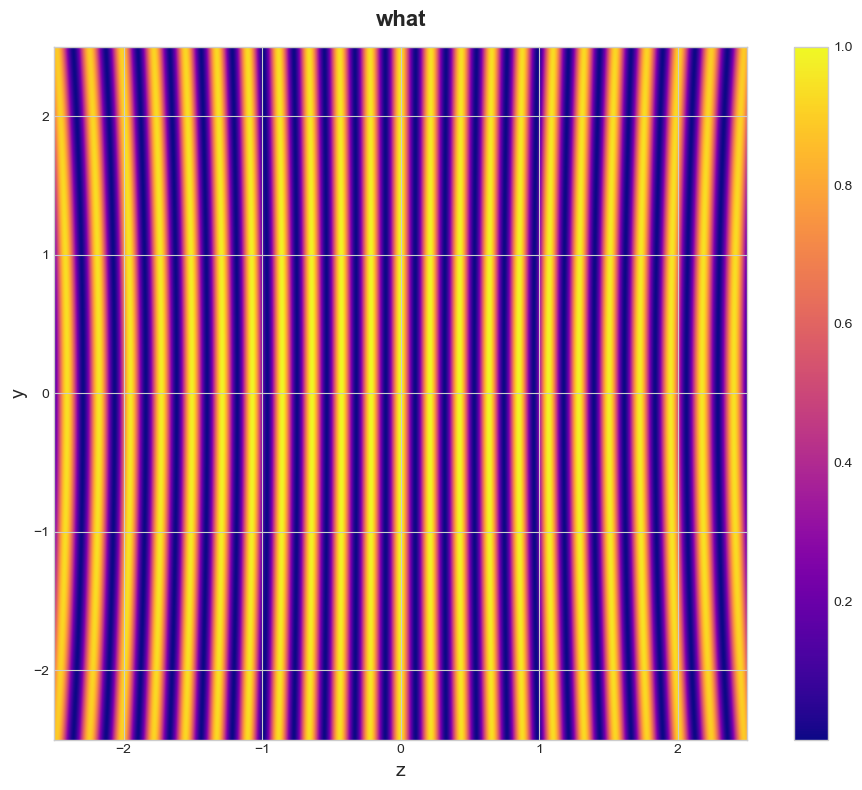

In [4]:
# matrices s1 y s2
s1 = np.sqrt(x**2 + Y**2 + (Z - a/2)**2)
s2 = np.sqrt(x**2 + Y**2 + (Z + a/2)**2)

# intensidad
I1 = I0/(s1**2)
I2 = I0/(s2**2)
I = I1 + I2 + 2 * np.sqrt(I1 * I2) * np.cos(2 * np.pi * (s2-s1) / lmd)
Inorm = I/np.max(I)

# graph
plt.style.use('seaborn-v0_8-whitegrid')  
fig, ax = plt.subplots(figsize=(10, 8))

# capture the QuadContourSet returned by imshow and pass it to colorbar
# use the physical coordinates (vec -> z/y) so columns map to z (horizontal) and rows to y (vertical)
cs = ax.imshow(Inorm,
               extent=(vec.min(), vec.max(), vec.min(), vec.max()),
               origin='lower',     # flip so +y is up
               cmap='plasma',
               aspect='equal')
ax.set_xlabel('z [cm]')
ax.set_ylabel('y [cm]')
ax.set_ylabel('y', fontsize=14)
ax.set_xlabel('z', fontsize=14)
ax.set_title('what', fontsize=16, fontweight='bold', pad=15)
ax.tick_params(axis='both', which='major', labelsize=10)
fig.colorbar(cs, ax=ax)
# ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
# plt.savefig('Srel.png', dpi=300)
plt.show()

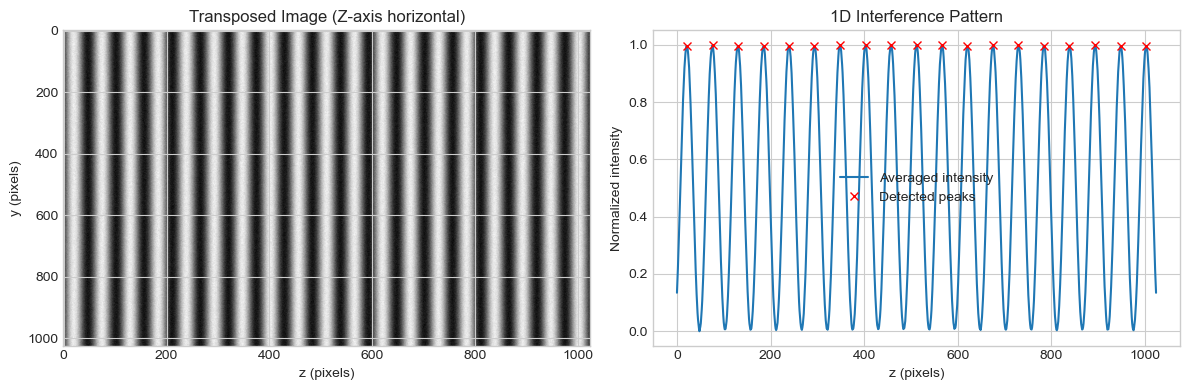

Number of detected peaks: 19
Mean fringe spacing: 54.56 ± 0.68 px
Pixel scale: 9.766e-04 cm/px
Fringe spacing: 5.3277e-02 ± 6.7e-04 cm
Estimated source separation a = 9.9856e-03 ± 1.3e-04 cm
Which is a = 0.0999 ± 0.00 mm


In [5]:
# === Parameters (edit if needed) ===
filename = "data/FranjasParalelas.tif"
width_cm = 1.0       # physical width of the image (cm)
x_cm = 10.0           # distance from sources to screen (cm)
lmd_cm = 5.32e-5      # wavelength in cm (532 nm green laser)

# === 1. Load and preprocess image ===
# Read as grayscale (0–255)
img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
if img is None:
    raise FileNotFoundError(f"Image '{filename}' not found.")

# Transpose so horizontal axis aligns with z
arr_t = img.T.astype(float)

# Normalize intensities 0–1
arr_t = (arr_t - arr_t.min()) / (arr_t.max() - arr_t.min())

# === 2. Average along y-axis to get 1D intensity profile ===
profile = arr_t.mean(axis=0)
profile_norm = (profile - profile.min()) / (profile.max() - profile.min())

# === 3. Find peaks in the intensity profile ===
peaks, props = find_peaks(profile_norm, prominence=0.2, distance=10)

# === 4. Compute fringe spacing in pixels ===
spacings_px = np.diff(peaks)
mean_spacing_px = spacings_px.mean()
std_spacing_px = spacings_px.std()

# === 5. Convert pixels to cm ===
n_cols = arr_t.shape[1]
pix_to_cm = width_cm / (n_cols - 1)
mean_spacing_cm = mean_spacing_px * pix_to_cm
std_spacing_cm = std_spacing_px * pix_to_cm

# === 6. Compute slit/source separation a ===
# Formula: Δz = λ x / a  =>  a = λ x / Δz
a_cm = lmd_cm * x_cm / mean_spacing_cm
a_std_cm = (lmd_cm * x_cm / (mean_spacing_cm**2)) * std_spacing_cm

# Convert to mm for readability
a_mm = a_cm * 10.0
a_std_mm = a_std_cm * 10.0

# === 7. Plot the results ===
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Original transposed image
axs[0].imshow(arr_t, cmap='gray', aspect='auto')
axs[0].set_title("Transposed Image (Z-axis horizontal)")
axs[0].set_xlabel("z (pixels)")
axs[0].set_ylabel("y (pixels)")

# Averaged intensity profile with detected peaks
axs[1].plot(profile_norm, label='Averaged intensity')
axs[1].plot(peaks, profile_norm[peaks], 'rx', label='Detected peaks')
axs[1].set_xlabel("z (pixels)")
axs[1].set_ylabel("Normalized intensity")
axs[1].set_title("1D Interference Pattern")
axs[1].legend()

plt.tight_layout()
plt.show()

# === 8. Print numeric results ===
print(f"Number of detected peaks: {len(peaks)}")
print(f"Mean fringe spacing: {mean_spacing_px:.2f} ± {std_spacing_px:.2f} px")
print(f"Pixel scale: {pix_to_cm:.3e} cm/px")
print(f"Fringe spacing: {mean_spacing_cm:.4e} ± {std_spacing_cm:.1e} cm")
print(f"Estimated source separation a = {a_cm:.4e} ± {a_std_cm:.1e} cm")
print(f"Which is a = {a_mm:.4f} ± {a_std_mm:.2f} mm")

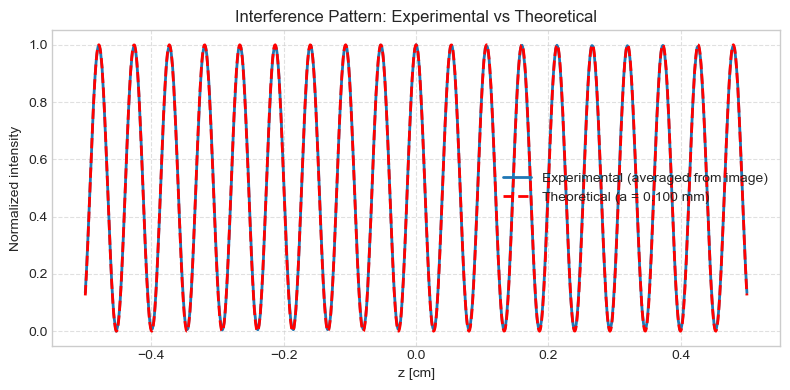

In [6]:
# === 9. Compare experimental vs. theoretical pattern ===

# 1D coordinate (in cm)
z_pixels = np.arange(profile_norm.size)
z_cm = (z_pixels - z_pixels.mean()) * pix_to_cm  # center at z=0

# theoretical intensity pattern using the estimated a
I_theo = 1 + np.cos(2 * np.pi * a_cm * z_cm / (lmd_cm * x_cm))
I_theo_norm = (I_theo - I_theo.min()) / (I_theo.max() - I_theo.min())

# --- plot comparison ---
plt.figure(figsize=(8,4))
plt.plot(z_cm, profile_norm, label='Experimental (averaged from image)', lw=2)
plt.plot(z_cm, I_theo_norm, '--r', label=f'Theoretical (a = {a_mm:.3f} mm)', lw=2)
plt.xlabel('z [cm]')
plt.ylabel('Normalized intensity')
plt.title('Interference Pattern: Experimental vs Theoretical')
plt.legend()
plt.grid(True, ls='--', alpha=0.6)
plt.tight_layout()
plt.show()

### data

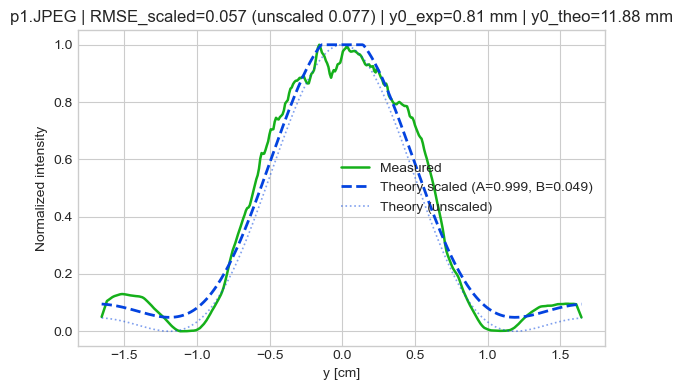


=== Single-slit comparison summary (given a or b) ===
p1.JPEG               RMSE_scaled=0.057 (unscaled 0.077)  A=0.999  B=0.049  y0_exp=0.81 mm  y0_theo=11.88 mm  b_est=1991.71 µm  (a=272.1 µm, b=136.1 µm)


In [17]:
# === Single-slit analysis: compare experimental profiles to theoretical curve (given b or a) ===
# Configure here ↓
# Path pattern for images (supports JPEG/JPG/PNG/TIF/TIFF).
#   glob_pattern = "data/single/*.JPEG"
#   glob_pattern = "data/d3/*.JPEG"
#   glob_pattern = "data/single/*.tif"
glob_pattern = "data/s1/*.JPEG"

width_cm = 3.3             # physical width of the image field of view (cm)
lmd = 650e-9                 # wavelength [m]
z_m = 4.973                  # observation distance [m]

# Slit width: use either full width 'a_given_m' OR half-width 'b_given_m'.
# Exactly one of them should be non-None.
a_given_m = 0.0002721          # full slit width a [m] (example: 0.29 mm)
b_given_m = None             # half slit width b [m] (set if you want to specify b directly)

# --- resolve a/b consistently ---
if (a_given_m is None) and (b_given_m is None):
    raise ValueError("Provide either a_given_m (full width) or b_given_m (half-width).")
if a_given_m is None:
    a_given_m = 2.0 * float(b_given_m)
if b_given_m is None:
    b_given_m = 0.5 * float(a_given_m)

def single_slit_theory(y_m, a_m, lmd_m, z_m):
    """
    Normalized Fraunhofer single-slit intensity profile along screen coordinate y (meters).
    I(y) ∝ sinc^2(a y / (λ z)), where numpy's sinc is sin(πx)/(πx).
    a is the FULL slit width; if you have b (half-width), use a = 2b.
    """
    I = np.sinc(a_m * y_m / (lmd_m * z_m)) ** 2
    # normalize for fair comparison
    I = (I - I.min()) / (I.max() - I.min()) if I.max() > I.min() else I
    return I

# Selection options
only_numeric_names = False     # keep only files whose stem has no letters; set False to keep all
select_by_indices = []         # e.g., [1, 3, 5]; empty -> keep all found
select_by_names = ["p1.JPEG"]  # e.g., ["1.JPEG", "7.JPG"]; empty -> ignore

# --- Discover images (multiple extensions supported) ---

def discover_images(pattern):
    base = os.path.dirname(pattern)
    exts = ["*.JPEG", "*.JPG", "*.jpg", "*.jpeg", "*.png", "*.tif", "*.tiff"]
    paths = []
    for ext in exts:
        paths.extend(glob.glob(os.path.join(base, ext)))
    # optional filter: numeric-only stems
    out = []
    for p in paths:
        s = os.path.splitext(os.path.basename(p))[0]
        if only_numeric_names and re.search(r"[A-Za-z]", s):
            continue
        out.append(p)
    # numeric sort when possible
    def _num_key(p):
        s = os.path.splitext(os.path.basename(p))[0]
        m = re.search(r"(\d+)", s)
        return int(m.group(1)) if m else s
    return sorted(out, key=_num_key)

images = discover_images(glob_pattern)

# apply selection filters
if select_by_names:
    names_set = set(select_by_names)
    images = [p for p in images if os.path.basename(p) in names_set]
elif select_by_indices:
    keep = set(select_by_indices)
    filtered = []
    for p in images:
        m = re.search(r"(\d+)", os.path.splitext(os.path.basename(p))[0])
        if m and int(m.group(1)) in keep:
            filtered.append(p)
    images = filtered

if not images:
    raise RuntimeError("No images selected; adjust glob_pattern/filters or check data path.")

# --- Analysis ---
N_summary = []
rmse_unscaled_list = []
rmse_scaled_list = []
y0_exp_list = []
y0_theo_list = []
b_est_list = []
AB_list = []

for fname in images:
    img = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"⚠️ Could not load {fname}")
        continue

    # normalize image 0–1 and average along vertical axis (rows) to get 1D profile along columns
    arr = img.astype(float)
    arr = (arr - arr.min()) / (arr.max() - arr.min())
    profile = arr.mean(axis=0)
    # light smoothing to stabilize minima detection
    if profile.size > 15:
        k = 9
        kernel = np.ones(k)/k
        profile = np.convolve(profile, kernel, mode='same')
    profile_norm = (profile - profile.min()) / (profile.max() - profile.min()) if profile.max() > profile.min() else profile

    # pixel → meter conversion using the field width
    N = profile_norm.size
    pix_to_m = (width_cm / 100.0) / (N - 1)
    y_m = (np.arange(N) - N/2) * pix_to_m

    # theoretical single-slit intensity using FULL width a = 2b
    I_theo = single_slit_theory(y_m, a_given_m, lmd, z_m)

    # RMSE without scaling
    rmse_unscaled = float(np.sqrt(np.mean((profile_norm - I_theo)**2)))

    # Fit amplitude and offset: y ≈ A*I_theo + B
    X = np.vstack([I_theo, np.ones_like(I_theo)]).T
    A, B = np.linalg.lstsq(X, profile_norm, rcond=None)[0]
    I_fit = A * I_theo + B
    I_fit = np.clip(I_fit, 0.0, 1.0)

    rmse_scaled = float(np.sqrt(np.mean((profile_norm - I_fit)**2)))

    # detect central maximum and nearest minima on both sides (for y0 estimate)
    peaks, _ = find_peaks(profile_norm, prominence=0.05, distance=10)
    if len(peaks) == 0:
        cidx = int(np.argmax(profile_norm))
    else:
        cidx = int(peaks[np.argmax(profile_norm[peaks])])

    minima, _ = find_peaks(-profile_norm, prominence=0.02, distance=10)
    left_candidates = minima[minima < cidx]
    right_candidates = minima[minima > cidx]

    y0_left = np.nan
    y0_right = np.nan
    if left_candidates.size:
        y0_left = abs((left_candidates[-1] - cidx) * pix_to_m)
    if right_candidates.size:
        y0_right = abs((right_candidates[0] - cidx) * pix_to_m)

    if np.isfinite(y0_left) and np.isfinite(y0_right):
        y0_exp = 0.5*(y0_left + y0_right)
    elif np.isfinite(y0_left):
        y0_exp = y0_left
    elif np.isfinite(y0_right):
        y0_exp = y0_right
    else:
        y0_exp = np.nan

    # theoretical first-zero distance: y0 = λ z / a
    y0_theo = lmd * z_m / a_given_m

    # estimate b from first-zero distance: y0 = λ z / (2b) ⇒ b = λ z / (2 y0)
    if np.isfinite(y0_exp) and y0_exp > 0:
        b_est = lmd * z_m / (2 * y0_exp)
    else:
        b_est = np.nan

    # plot overlay
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(6, 4))
    plt.plot(y_m*100, profile_norm, label="Measured", lw=1.8, color='xkcd:green')
    plt.plot(y_m*100, I_fit, "--", label=f"Theory scaled (A={A:.3f}, B={B:.3f})", lw=2, color='xkcd:blue')
    # optional: faint unscaled reference
    plt.plot(y_m*100, I_theo, ":", label="Theory (unscaled)", lw=1.2, color='xkcd:blue', alpha=0.5)
    ttl = (
        f"{os.path.basename(fname)} | RMSE_scaled={rmse_scaled:.3f} (unscaled {rmse_unscaled:.3f}) | "
        f"y0_exp={y0_exp*1e3 if np.isfinite(y0_exp) else np.nan:.2f} mm | "
        f"y0_theo={y0_theo*1e3:.2f} mm"
    )
    plt.title(ttl)
    plt.xlabel("y [cm]")
    plt.ylabel("Normalized intensity")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # store summary
    N_summary.append(N)
    rmse_unscaled_list.append(rmse_unscaled)
    rmse_scaled_list.append(rmse_scaled)
    y0_exp_list.append(y0_exp)
    y0_theo_list.append(y0_theo)
    b_est_list.append(b_est)
    AB_list.append((A, B))

# summary table
print("\n=== Single-slit comparison summary (given a or b) ===")
for i, fname in enumerate(images):
    y0e = y0_exp_list[i]
    y0t = y0_theo_list[i]
    be = b_est_list[i]
    A, B = AB_list[i]
    print(
        f"{os.path.basename(fname):20s}  "
        f"RMSE_scaled={rmse_scaled_list[i]:.3f} (unscaled {rmse_unscaled_list[i]:.3f})  "
        f"A={A:.3f}  B={B:.3f}  "
        f"y0_exp={(y0e*1e3):.2f} mm  "
        f"y0_theo={(y0t*1e3):.2f} mm  "
        f"b_est={(be*1e6) if np.isfinite(be) else np.nan:.2f} µm  "
        f"(a={a_given_m*1e6:.1f} µm, b={b_given_m*1e6:.1f} µm)"
    )

## parte 2

### model

In [ ]:
# === Physical constants ===
lmd = 532e-9   # wavelength [m]
z = 4.0         # observation distance [m]
b = 25e-6       # half slit height [m]
c = 0.5e-3      # slit center distance [m]

# === Grid parameters ===
res = 1025
L = 0.05        # 5 cm window [m]
vec = np.linspace(-L/2, L/2, res)
Y, Z = np.meshgrid(vec, vec)

# === 1. Compute theoretical intensity ===
I = (np.sinc(2*b*Y/(lmd*z))**2) * (np.cos(2*np.pi*c*Y/(lmd*z))**2)
I /= I.max()

# === 2. Plot the 2D diffraction pattern ===
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(8,6))
im = ax.imshow(I, extent=(vec.min()*100, vec.max()*100, vec.min()*100, vec.max()*100),
               origin='upper', cmap='plasma', aspect='auto')
ax.set_xlabel('z [cm]')
ax.set_ylabel('y [cm]')
ax.set_title('Patrón de difracción (Fraunhofer, doble rendija)', fontsize=14, fontweight='bold')
fig.colorbar(im, ax=ax, label='Intensidad normalizada')
plt.tight_layout()
plt.show()

# === 3. Load experimental image and estimate b, c ===
filename = "data/FranjasRendijas.tif"
img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
if img is None:
    raise FileNotFoundError(f"Image '{filename}' not found.")

# transpose and normalize
img_t = img.astype(float)
img_t = (img_t - img_t.min()) / (img_t.max() - img_t.min())

# average over y to get 1D experimental profile
profile = img_t.mean(axis=0)
profile_norm = (profile - profile.min()) / (profile.max() - profile.min())

# find maxima (interference fringes)
peaks, _ = find_peaks(profile_norm, prominence=0.2, distance=10)

# spacing in pixels and meters
spacings_px = np.diff(peaks)
mean_spacing_px = spacings_px.mean()
width_cm = 1.0    # as stated in problem
pix_to_m = (width_cm / 100) / (profile_norm.size - 1)
mean_spacing_m = mean_spacing_px * pix_to_m

# estimate parameters from spacing
# interference spacing Δy ≈ λ z / (2 c)
c_est = lmd * z / (2 * mean_spacing_m)

# envelope width gives first zero of sinc² ≈ λ z / (2 b)
minima, _ = find_peaks(-profile_norm, prominence=0.2)
if len(minima) >= 2:
    envelope_width_px = abs(minima[-1] - minima[0]) / 2
    b_est = lmd * z / (2 * envelope_width_px * pix_to_m)
else:
    b_est = np.nan

# === 4. Compare experimental and theoretical 1D profiles ===
z_pixels = np.arange(profile_norm.size)
z_m = (z_pixels - z_pixels.mean()) * pix_to_m

I_theo_est = (np.sinc(2*b_est*z_m/(lmd*z))**2) * (np.cos(2*np.pi*c_est*z_m/(lmd*z))**2)
I_theo_est = (I_theo_est - I_theo_est.min()) / (I_theo_est.max() - I_theo_est.min())

plt.figure(figsize=(9,4))
plt.plot(z_m*100, profile_norm, lw=2, label='Perfil experimental')
plt.plot(z_m*100, I_theo_est, '--r', lw=2, label='Patrón teórico ajustado')
plt.xlabel('y [cm]')
plt.ylabel('Intensidad normalizada')
plt.title('Comparación: Difracción doble rendija')
plt.legend()
plt.grid(True, ls='--', alpha=0.6)
plt.tight_layout()
plt.show()

# === 5. Print estimated values ===
print(f"Detected {len(peaks)} interference maxima")
print(f"Mean fringe spacing Δy = {mean_spacing_m*1e3:.4f} mm")
print(f"Estimated c = {c_est*1e3:.4f} mm (theoretical = {c*1e3:.4f} mm)")
print(f"Estimated b = {b_est*1e6:.2f} µm (theoretical = {b*1e6:.2f} µm)")

### data

In [ ]:
import glob, re
import os

# === Constants ===
lmd = 650e-9  # wavelength [m]

# === Experimental setup data ===
# auto-discover image files and sort by numeric index in filename

slit = 3 # choose slit set (1, 2, or 3)
width_cm = [14.8, 7.1, 11.8][slit - 1]
raw_images = glob.glob(f"data/d{slit}/*.JPEG")
# keep only files whose basename (without extension) has no letters
images = []
for p in raw_images:
    stem = os.path.splitext(os.path.basename(p))[0]
    if re.search(r'[A-Za-z]', stem):
        continue
    images.append(p)

def _num_key(p):
    s = os.path.splitext(os.path.basename(p))[0]
    m = re.search(r'(\d+)', s)
    return int(m.group(1)) if m else s

images = sorted(images, key=_num_key)

# single constants expanded to match number of images
n = len(images)
z_values = [4.973] * n        # distances [m]
widths_cm = [width_cm] * n        # real width of image [cm]

# === Initialize arrays to store results ===
b_list = []
c_list = []
dy_list = []

# === Loop through all experimental images ===
for fname, z, width_cm in zip(images, z_values, widths_cm):
    img = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"⚠️ Could not load {fname}")
        continue

    img_t = img.astype(float)
    img_t = (img_t - img_t.min()) / (img_t.max() - img_t.min())

    # Average over y to get 1D profile
    profile = img_t.mean(axis=0)
    profile_norm = (profile - profile.min()) / (profile.max() - profile.min())

    # Pixel to meter conversion
    pix_to_m = (width_cm / 100) / (len(profile_norm) - 1)

    # Find interference peaks
    peaks, _ = find_peaks(profile_norm, prominence=0.2, distance=10)
    if len(peaks) < 2:
        print(f"⚠️ Not enough peaks detected in {fname}")
        continue

    spacings_px = np.diff(peaks)
    mean_spacing_px = spacings_px.mean()
    mean_spacing_m = mean_spacing_px * pix_to_m

    # Estimate c (slit separation)
    c_est = lmd * z / (2 * mean_spacing_m)

    # Estimate b (half slit width) from envelope width
    minima, _ = find_peaks(-profile_norm, prominence=0.2)
    if len(minima) >= 2:
        envelope_width_px = abs(minima[-1] - minima[0]) / 2
        b_est = lmd * z / (2 * envelope_width_px * pix_to_m)
    else:
        b_est = np.nan

    # Store results
    b_list.append(b_est)
    c_list.append(c_est)
    dy_list.append(mean_spacing_m)

    # Plot each individual profile (optional)
    x_m = (np.arange(len(profile_norm)) - len(profile_norm)/2) * pix_to_m
    plt.figure(figsize=(8,3))
    plt.plot(x_m*100, profile_norm, 'k-', lw=1.5)
    plt.title(f"{fname} — z={z:.2f} m, width={width_cm:.2f} cm")
    plt.xlabel("y [cm]")
    plt.ylabel("Intensidad normalizada")
    plt.tight_layout()
    plt.show()

# === Summarize all results ===
b_list = np.array(b_list)
c_list = np.array(c_list)
dy_list = np.array(dy_list)

print("\n=== Experimental Results ===")
for i, (fname, z, width, b_est, c_est) in enumerate(zip(images, z_values, widths_cm, b_list, c_list)):
    print(f"{fname:15s} | z = {z:.2f} m | width = {width:.2f} cm | "
          f"b = {b_est*1e6:6.2f} µm | c = {c_est*1e3:6.3f} mm")

# === Trend plots ===
plt.figure(figsize=(6,4))
plt.plot(z_values, np.array(c_list)*1e3, 'o-', lw=2)
plt.xlabel('Distancia z [m]')
plt.ylabel('Separación entre rendijas c [mm]')
plt.title('Estimación de c vs z')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(z_values, np.array(b_list)*1e6, 's-', lw=2, color='orange')
plt.xlabel('Distancia z [m]')
plt.ylabel('Ancho de rendija b [µm]')
plt.title('Estimación de b vs z')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# === Compare experimental profiles to theoretical curve (given b and c) ===
# Configure here ↓
slit = 3                     # choose slit set (1, 2, or 3)
width_cm_lookup = {1: 14.8, 2: 7.1, 3: 11.8}
width_cm = width_cm_lookup[slit]

lmd = 650e-9                 # wavelength [m]
z_m = 4.973                  # observation distance [m]
b_given = 7.15e-5              # half slit height b [m]
c_given = 1.285e-4             # slit center distance c [m]

# Select specific images to compare.
# Option A: by numeric indices in filename (e.g., .../12.JPEG -> 12)
select_by_indices = [8, 6]        # set [] to use all discovered images
# Option B: by exact basenames (e.g., ["1.JPEG", "3.JPEG"]). Leave empty to ignore.
select_by_names = []

# --- Discover and filter images ---
import glob, os, re
raw_images = glob.glob(f"data/d{slit}/*.JPEG")
# keep files whose basename (without extension) contains no letters
images = []
for p in raw_images:
    stem = os.path.splitext(os.path.basename(p))[0]
    if re.search(r"[A-Za-z]", stem):
        continue
    images.append(p)

def _num_key(p):
    s = os.path.splitext(os.path.basename(p))[0]
    m = re.search(r"(\d+)", s)
    return int(m.group(1)) if m else s

images = sorted(images, key=_num_key)

# apply selection, if provided
if select_by_names:
    names_set = set(select_by_names)
    images = [p for p in images if os.path.basename(p) in names_set]
elif select_by_indices:
    keep = set(select_by_indices)
    filtered = []
    for p in images:
        m = re.search(r"(\d+)", os.path.splitext(os.path.basename(p))[0])
        if m and int(m.group(1)) in keep:
            filtered.append(p)
    images = filtered

if not images:
    raise RuntimeError("No images selected; adjust select_by_indices/select_by_names or check data path.")

# --- Compare experimental 1D profile vs theoretical curve ---
rmse_list = []
peak_spacing_exp_list = []
peak_spacing_theo_list = []

for fname in images:
    img = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"⚠️ Could not load {fname}")
        continue

    # normalize image 0–1 and average along vertical axis to get 1D profile
    arr = img.astype(float)
    arr = (arr - arr.min()) / (arr.max() - arr.min())
    profile = arr.mean(axis=0)
    profile_norm = (profile - profile.min()) / (profile.max() - profile.min())

    # pixel → meter conversion (assuming full image width corresponds to width_cm)
    N = profile_norm.size
    pix_to_m = (width_cm / 100.0) / (N - 1)
    y_m = (np.arange(N) - N/2) * pix_to_m

    # theoretical intensity (Fraunhofer, double slit)
    # keep same functional form used above in the notebook for consistency
    I_theo = (np.sinc(2*b_given*y_m/(lmd*z_m))**2) * (np.cos(2*np.pi*c_given*y_m/(lmd*z_m))**2)
    I_theo = (I_theo - I_theo.min()) / (I_theo.max() - I_theo.min())

    # basic error metric
    rmse = np.sqrt(np.mean((profile_norm - I_theo)**2))
    rmse_list.append(rmse)

    # experimental mean fringe spacing (for reference)
    peaks, _ = find_peaks(profile_norm, prominence=0.2, distance=10)
    if len(peaks) >= 2:
        spacing_px = np.diff(peaks).mean()
        peak_spacing_exp_m = spacing_px * pix_to_m
    else:
        peak_spacing_exp_m = np.nan
    peak_spacing_exp_list.append(peak_spacing_exp_m)

    # theoretical fringe spacing Δy ≈ λ z / (2 c)
    peak_spacing_theo = lmd * z_m / (2 * c_given)
    peak_spacing_theo_list.append(peak_spacing_theo)

    # plot overlay
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(6, 4))
    plt.plot(y_m*100, profile_norm, label="Measured", lw=1.8, color='xkcd:green')
    plt.plot(y_m*100, I_theo, "--", label="Nominal", lw=2, color='xkcd:violet')
    ttl = (
        f"{os.path.basename(fname)} | RMSE={rmse:.3f} | "
        f"Δy_exp={peak_spacing_exp_m*1e3:.2f} mm | Δy_theo={peak_spacing_theo*1e3:.2f} mm"
    )
    plt.title(ttl)
    plt.xlabel("y [cm]")
    plt.ylabel("Normalized intensity")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"comparison_{slit}_{os.path.splitext(os.path.basename(fname))[0]}.png", dpi=300)
    plt.show()

# summary table
print("\n=== Comparison summary (given b, c) ===")
for i, fname in enumerate(images):
    dy_exp_mm = (peak_spacing_exp_list[i]*1e3) if not np.isnan(peak_spacing_exp_list[i]) else np.nan
    dy_theo_mm = peak_spacing_theo_list[i]*1e3
    print(f"{os.path.basename(fname):20s}  RMSE={rmse_list[i]:.3f}  Δy_exp={dy_exp_mm:.2f} mm  Δy_theo={dy_theo_mm:.2f} mm")